In [1]:
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
import segmentation_models as sm

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from smooth_tiled_predictions import predict_img_with_smooth_windowing
from simple_unet_model_with_jacard import jacard_coef  


Segmentation Models: using `keras` framework.


In [2]:
img = cv2.imread("C:/Users/arvin/OneDrive/Desktop/UNET/data/MakeRas_20230211_1.jpg", 1)
original_mask = cv2.imread("C:/Users/arvin/OneDrive/Desktop/UNET/masks/masktest3.png", 1)
original_mask = cv2.cvtColor(original_mask,cv2.COLOR_BGR2RGB)


In [3]:
from keras.models import load_model

model = load_model("C:/python_for_microscopists-master/mangrove.hdf5", compile=False)
                  
# size of patches
patch_size = 256

# Number of classes 
n_classes = 5


In [4]:
SIZE_X = (img.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
SIZE_Y = (img.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
large_img = Image.fromarray(img)
large_img = large_img.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
#image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
large_img = np.array(large_img)     


In [5]:
patches_img = patchify(large_img, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
patches_img = patches_img[:,:,0,:,:,:]

patched_prediction = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        
        single_patch_img = patches_img[i,j,:,:,:]
        
        #Use minmaxscaler instead of just dividing by 255. 
        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
        single_patch_img = np.expand_dims(single_patch_img, axis=0)
        pred = model.predict(single_patch_img)
        pred = np.argmax(pred, axis=3)
        pred = pred[0, :,:]
                                 
        patched_prediction.append(pred)


1/1 [==============================] - 0s 77ms/step


(-0.5, 2047.5, 2047.5, -0.5)

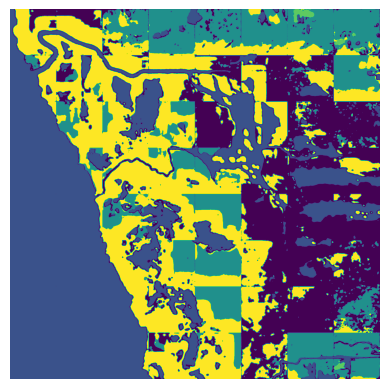

In [6]:
patched_prediction = np.array(patched_prediction)
patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1], 
                                            patches_img.shape[2], patches_img.shape[3]])

unpatched_prediction = unpatchify(patched_prediction, (large_img.shape[0], large_img.shape[1]))

plt.imshow(unpatched_prediction)
plt.axis('off')


In [7]:
input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

# Use the algorithm. The `pred_func` is passed and will process all the image 8-fold by tiling small patches with overlap, called once with all those image as a batch outer dimension.
# Note that model.predict(...) accepts a 4D tensor of shape (batch, x, y, nb_channels), such as a Keras model.
predictions_smooth = predict_img_with_smooth_windowing(
    input_img,
    window_size=patch_size,
    subdivisions=10,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)


final_prediction = np.argmax(predictions_smooth, axis=2)


  0%|          | 0/8 [00:00<?, ?it/s]

10/10 [==============================] - 10s 1s/step


 12%|█▎        | 1/8 [00:13<01:36, 13.77s/it]

10/10 [==============================] - 11s 1s/step


 25%|██▌       | 2/8 [00:28<01:26, 14.36s/it]

10/10 [==============================] - 12s 1s/step


 38%|███▊      | 3/8 [00:44<01:16, 15.23s/it]

10/10 [==============================] - 12s 1s/step


 50%|█████     | 4/8 [01:01<01:03, 15.78s/it]

10/10 [==============================] - 11s 1s/step


 62%|██████▎   | 5/8 [01:16<00:46, 15.45s/it]

10/10 [==============================] - 11s 1s/step


 75%|███████▌  | 6/8 [01:32<00:31, 15.55s/it]

10/10 [==============================] - 12s 1s/step


 88%|████████▊ | 7/8 [01:48<00:15, 15.98s/it]

10/10 [==============================] - 12s 1s/step


100%|██████████| 8/8 [02:04<00:00, 15.61s/it]


In [12]:
def label_to_rgb(predicted_image):
    
    Black_mangrove = '000000'
    Black_mangrove = np.array(tuple(int(Black_mangrove[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

    Water = '0000FF'
    Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

    White_mangrove = 'FFFFFF' 
    White_mangrove = np.array(tuple(int(White_mangrove[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

    Other =  '00FF00' 
    Other = np.array(tuple(int(Other[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

    Red_mangrove = 'FF0000' 
    Red_mangrove = np.array(tuple(int(Red_mangrove[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

    
    
    segmented_img = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3))
    
    segmented_img[(predicted_image == 0)] = Black_mangrove
    segmented_img[(predicted_image == 1)] = Water
    segmented_img[(predicted_image == 2)] = White_mangrove
    segmented_img[(predicted_image == 3)] = Other
    segmented_img[(predicted_image == 4)] = Red_mangrove
    
    segmented_img = segmented_img.astype(np.uint8)
    return(segmented_img)


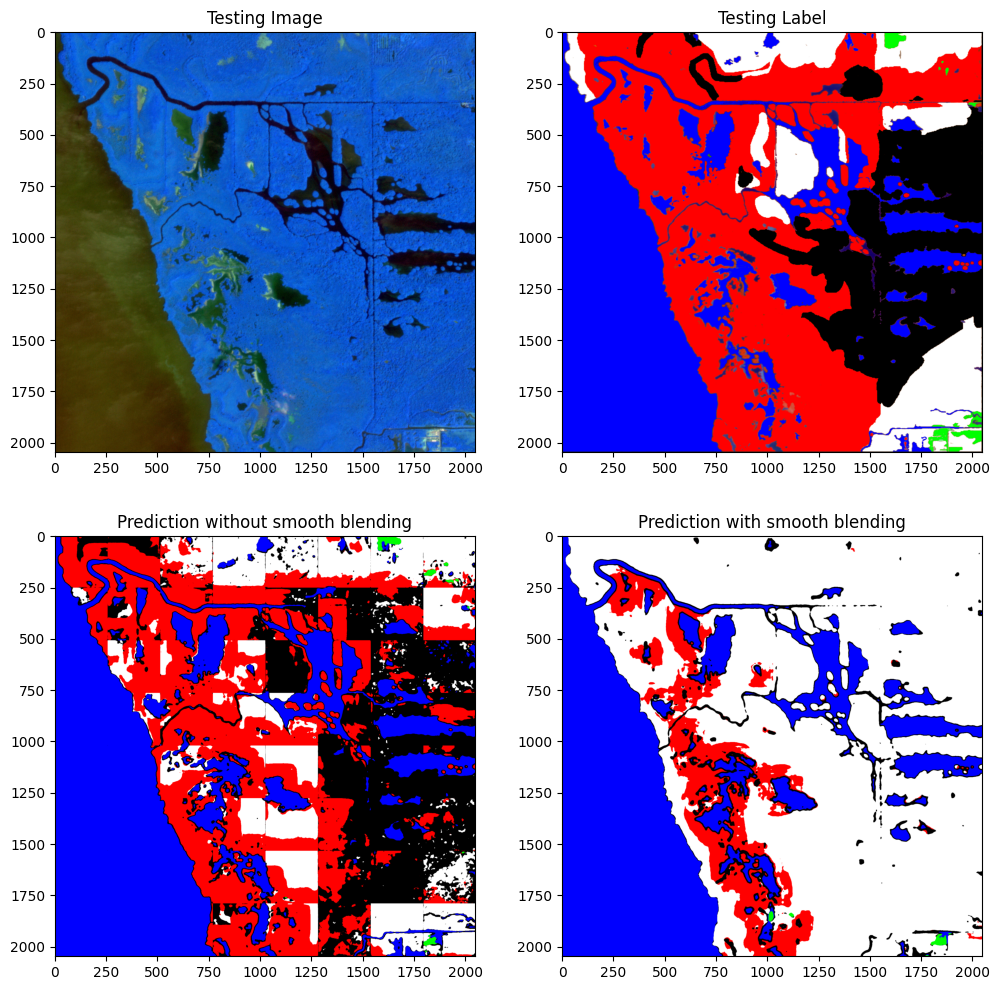

In [14]:
prediction_with_smooth_blending=label_to_rgb(final_prediction)
prediction_without_smooth_blending=label_to_rgb(unpatched_prediction)
predictions_smooth=label_to_rgb(final_prediction)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Testing Label')
plt.imshow(original_mask)
plt.subplot(223)
plt.title('Prediction without smooth blending')
plt.imshow(prediction_without_smooth_blending)
plt.subplot(224)
plt.title('Prediction with smooth blending')
plt.imshow(predictions_smooth)
plt.show()

plt.imsave('C:/Users/arvin/OneDrive/Desktop/UNET/prediction/'+'without_smoothblend1_'+'_1'+".png", prediction_without_smooth_blending)
plt.imsave('C:/Users/arvin/OneDrive/Desktop/UNET/prediction/'+'smoothblend1_'+'_1'+".png", prediction_with_smooth_blending)